# Load Libraries

In [1]:
import tensorflow as tf 
from keras.layers import Input, Conv1D, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, MaxPooling1D, concatenate, Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import os
import pickle
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import librosa
import keras
from sklearn.preprocessing import LabelEncoder
import sklearn
import itertools
from scipy.signal import find_peaks
import xgboost as xgb
import random

# Plot confusion matrix

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues , mode = 'normal'):
    if(mode == 'percent'):
        cm = cm*100/cm.sum()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, with little normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        strr = str(cm[i,j])
        if(mode == 'percent'):
            strr = str(round(cm[i, j] , 2)) + '%'
        plt.text(j, i, strr ,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Dataset preprocessing

In [4]:
def processPeaks(signal , plot = False):

    peaks, _ = find_peaks(signal, height=0)

    if(plot == True):
        plt.plot(signal)
        print(peaks)

    peak_cnt = len(peaks)
    peak_diff = 0
    for i in range(len(peaks)):
        if(i == 0):
            peak_diff += peaks[i] - 0
        else:
            peak_diff += peaks[i] - peaks[i-1]
    
    if(peak_cnt > 0): 
        peak_diff /= len(peaks)

    return peak_cnt, peak_diff

def preprocessOneVector(feature_vec):
    ax = []
    ay = []
    az = []
    for i in range(feature_vec.shape[0]):
        ax.append(feature_vec[i]['acc_x'])
        ay.append(feature_vec[i]['acc_y'])
        az.append(feature_vec[i]['acc_z'])

    fft_ax = np.fft.fft(ax)
    fft_ay = np.fft.fft(ay)
    fft_az = np.fft.fft(az)

    # MEAN
    ax_mean = np.mean(ax)
    ay_mean = np.mean(ay)
    az_mean = np.mean(az)
    fft_ax_mean = np.mean(fft_ax)
    fft_ay_mean = np.mean(fft_ay)
    fft_az_mean = np.mean(fft_az)

    # MEDIAN
    ax_median = np.median(ax)
    ay_median = np.median(ay)
    az_median = np.median(az)
    fft_ax_median = np.median(fft_ax)
    fft_ay_median = np.median(fft_ay)
    fft_az_median = np.median(fft_az)

    # MAGNITUDE
    mag = 0
    for i in range(feature_vec.shape[0]):
        val = 0
        val += feature_vec[i]['acc_x'] * feature_vec[i]['acc_x'] 
        val += feature_vec[i]['acc_y'] * feature_vec[i]['acc_y'] 
        val += feature_vec[i]['acc_z'] * feature_vec[i]['acc_z'] 
        mag += math.sqrt(val)
    mag /= feature_vec.shape[0]

    # CROSS-CORRELATION
    Corr_xz = np.correlate(ax , az)
    Corr_yz = np.correlate(ay , az)


    # AVG DIFF FROM MEAN
    avg_diff_x = 0
    avg_diff_y = 0
    avg_diff_z = 0
    for i in range(feature_vec.shape[0]):
        avg_diff_x += abs(ax_mean - ax[i])
        avg_diff_y += abs(ay_mean - ay[i])
        avg_diff_z += abs(az_mean - az[i])

    avg_diff_x /= feature_vec.shape[0]
    avg_diff_y /= feature_vec.shape[0]
    avg_diff_z /= feature_vec.shape[0]

    # SPECTRAL CENTROID
    spc_x = librosa.feature.spectral_centroid(np.array(ax))[0][0]
    spc_y = librosa.feature.spectral_centroid(np.array(ay))[0][0]
    spc_z = librosa.feature.spectral_centroid(np.array(az))[0][0]

    # PEAKS
    x_peak_cnt , x_peak_diff = processPeaks(ax)
    y_peak_cnt , y_peak_diff = processPeaks(ay)
    z_peak_cnt , z_peak_diff = processPeaks(az)


    feature_processed = [
        ax_mean, ay_mean, az_mean,
        fft_ax_mean.real, fft_ax_mean.imag, fft_ay_mean.real, fft_ay_mean.imag, 
        fft_az_mean.real, fft_az_mean.imag,

        ax_median, ay_median, az_median,
        fft_ax_median.real, fft_ax_median.imag, fft_ay_median.real, fft_ay_median.imag, 
        fft_az_median.real, fft_az_median.imag,

        mag,

        Corr_xz, Corr_yz,

        avg_diff_x, avg_diff_y, avg_diff_z,

        spc_x, spc_y , spc_z,

        # x_peak_cnt, x_peak_diff, y_peak_cnt, y_peak_diff, z_peak_cnt, z_peak_diff 
    ]

    return feature_processed

# PCA visualisation

In [5]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualizePCA2D(X , y , colors=None):

    pca = TSNE(n_components=2)
    principalComponents = pca.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents
                , columns = ['principal component 1', 'principal component 2'])
    # principalDf.head(5)

    #%%
    targetDf = pd.DataFrame(data = np.array(y) , columns = ['target'])
    # targetDf.head()

    #%%
    finalDf = pd.concat([principalDf, targetDf], axis = 1)
    print(finalDf.head(5))

    #%%
    # Visualize data
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 Component PCA', fontsize = 20)


    targets = list(set(y))

    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['target'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                , finalDf.loc[indicesToKeep, 'principal component 2']
                , c = color
                , s = 50)
    ax.legend(targets)
    ax.grid()

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import datasets
from sklearn.manifold import TSNE


def visualizePCA3D(X,y):
    np.random.seed(5)

    centers = [[1, 1], [-1, -1], [1, -1]]

    fig = plt.figure(1, figsize=(4, 3))
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

    plt.cla()
    pca = TSNE(n_components=3)
    # pca.fit(X)
    X = pca.fit_transform(X)

    le = LabelEncoder()
    y_le = le.fit_transform(y)

    arr = list(set(zip(y , y_le)))
    print(arr)

    print(X[0:5])
    for name, label in arr:
        ax.text3D(X[y == label, 0].mean(),
                X[y == label, 1].mean() + 1.5,
                X[y == label, 2].mean(), name,
                horizontalalignment='center',
                bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
    # Reorder the labels to have colors matching the cluster results


    yy = np.choose(y_le, list(set(y_le))).astype(np.float)

    print(X.shape, y.shape, y_le.shape, yy.shape)
    ax.scatter(
        X[:, 0], X[:, 1], X[:, 2], 
        c=yy, cmap='tab10',
        edgecolor='k'
    )

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])

    plt.show()


# Dataset Loading

In [7]:
import json
def loadJSONDataset(file_name):
    with open(file_name) as f:
        data = json.load(f)
    arr = np.array(json.loads(data[0]['vector']))
    print(arr)
    print(type(arr) , arr.shape)

    data_acc = []
    for reading in data:
        if(reading["sensor"] != "Accelerometer"):
            continue
        arr = np.array(json.loads(reading['vector']))
        data_acc.append({
            'acc_x': arr[0],
            'acc_y': arr[1],
            'acc_z': arr[2]
        })
    return np.array(data_acc)

def segmentaizeData(data_acc, block_size=100, interval=100):
    data_seg = []
    st = 0
    while(st + block_size < len(data_acc)):
        nd = st + block_size
        data_seg.append(data_acc[st:nd])
        st = st + interval
    data_seg = np.array(data_seg)
    return data_seg

def extractFeatureFromSegmentizeData(data_seg):
    data_feature = []
    for i in range(data_seg.shape[0]):
        feature_clean = preprocessOneVector(data_seg[i])
        data_feature.append(feature_clean)
    data_feature = np.array(data_feature)
    return data_feature

In [8]:
def loadNewData(user_data , folder_name):
    X = []
    y = []
    for (user_name, st, nd) in user_data:
        for i in range(st,nd+1):
            file_name = folder_name + '/'+user_name+str(i)+'.json'
            data = loadJSONDataset(file_name)
            data_seg = segmentaizeData(data, block_size=300, interval=50)
            data_feature = extractFeatureFromSegmentizeData(data_seg)

            print(user_name , i , "::", nd , data_feature.shape)
            for i in range(len(data_feature)):
                X.append(data_feature[i])
                y.append(user_name)
    
    zz = list(zip(X,y))
    random.shuffle(zz)
    X,y = zip(*zz)

    return np.array(X) , np.array(y)


In [9]:
# print('loading dataset')
# user_data = [
#     ('Razzak', 1,  2),
#     ('Tipu',1 , 2),
#     ('Sajib',1 , 2),
#     ('Tuhin', 1, 2),
#     ('Nayeem', 1, 2)
# ]

# X_train, y_train = loadNewData(user_data, "new_data_A1")
# print('>>>>>>>>>>>>>>>>>>>>>>>>> loaded train dataset :: ' , X_train.shape , y_train.shape)
# #%%
# test_data = [
#     ('Razzak', 3,  3),
#     ('Tipu',3 , 3),
#     ('Sajib',3 , 3),
#     ('Tuhin', 3, 3),
#     ('Nayeem', 3, 3)
# ]

# X_test, y_test = loadNewData(test_data , "new_data_A1")
# print('>>>>>>>>>>>>>>>>>>>>>>>>> loaded test dataset :: ' , X_test.shape , y_test.shape)


In [10]:
print('loading dataset')
user_data = [
    ('Razzak', 1,  3),
    ('Tipu',1 , 3),
    ('Sajib',1 , 3),
    ('Tuhin', 1, 3),
    ('Nayeem', 1, 3)
]

X_train, y_train = loadNewData(user_data , "new_data_A1")
print('>>>>>>>>>>>>>>>>>>>>>>>>> loaded train dataset :: ' , X_train.shape , y_train.shape)

loading dataset
[58.]
<class 'numpy.ndarray'> (1,)
Razzak 1 :: 3 (120, 27)
[159.]
<class 'numpy.ndarray'> (1,)
Razzak 2 :: 3 (163, 27)
[45.]
<class 'numpy.ndarray'> (1,)
Razzak 3 :: 3 (157, 27)
[238.]
<class 'numpy.ndarray'> (1,)
Tipu 1 :: 3 (170, 27)
[248.]
<class 'numpy.ndarray'> (1,)
Tipu 2 :: 3 (177, 27)
[43.]
<class 'numpy.ndarray'> (1,)
Tipu 3 :: 3 (169, 27)
[302.]
<class 'numpy.ndarray'> (1,)
Sajib 1 :: 3 (131, 27)
[506.]
<class 'numpy.ndarray'> (1,)
Sajib 2 :: 3 (161, 27)
[204.]
<class 'numpy.ndarray'> (1,)
Sajib 3 :: 3 (131, 27)
[233.]
<class 'numpy.ndarray'> (1,)
Tuhin 1 :: 3 (102, 27)
[168.]
<class 'numpy.ndarray'> (1,)
Tuhin 2 :: 3 (134, 27)
[102.]
<class 'numpy.ndarray'> (1,)
Tuhin 3 :: 3 (150, 27)
[164.]
<class 'numpy.ndarray'> (1,)
Nayeem 1 :: 3 (164, 27)
[117.]
<class 'numpy.ndarray'> (1,)
Nayeem 2 :: 3 (172, 27)
[271.]
<class 'numpy.ndarray'> (1,)
Nayeem 3 :: 3 (167, 27)
>>>>>>>>>>>>>>>>>>>>>>>>> loaded train dataset ::  (2268, 27) (2268,)


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=31)

print("Train", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)

Train (1519, 27) (1519,)
Test (749, 27) (749,)


In [12]:
# b : blue.
# g : green.
# r : red.
# c : cyan.
# m : magenta.
# y : yellow.
# k : black.
# w : white.

   principal component 1  principal component 2  target
0             -20.564159             -13.905263    Tipu
1               7.748877              -9.067640   Tuhin
2               1.417316             -14.385913   Tuhin
3               9.904160             -16.482597  Razzak
4             -55.540714               5.003991    Tipu


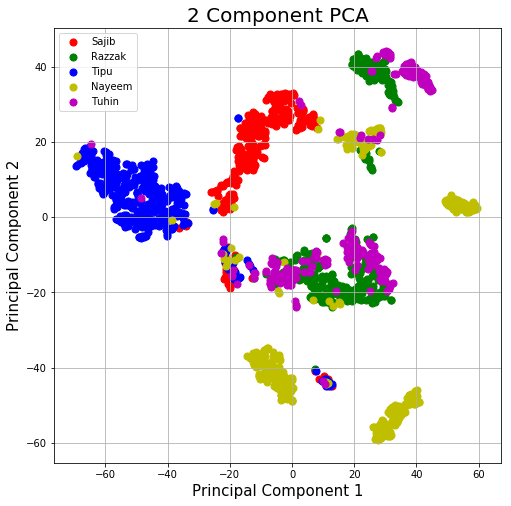

In [13]:
visualizePCA2D(X_train , y_train , colors = ['r' , 'g' , 'b' , 'y' , 'm'])

   principal component 1  principal component 2  target
0             -15.940019              -3.252476   Sajib
1             -38.425255               9.681566   Tuhin
2             -28.596189               8.129100  Razzak
3              -4.176984             -40.487778    Tipu
4              -0.756970             -37.279408    Tipu


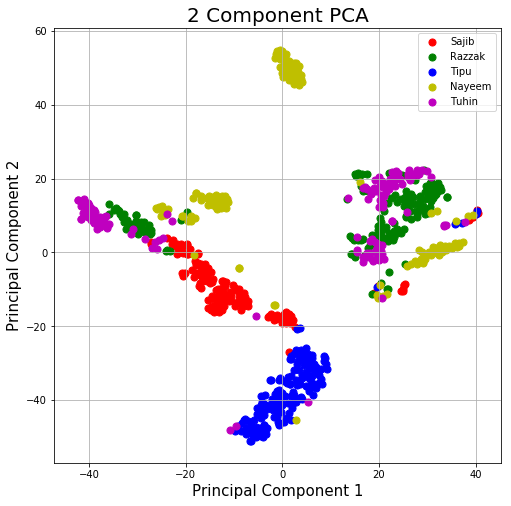

In [14]:
visualizePCA2D(X_test , y_test , colors = ['r' , 'g' , 'b' , 'y' , 'm'])

# Triplet code start

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context('notebook', font_scale=1.5,
                rc={"lines.linewidth": 2.5})

from sklearn.manifold import TSNE

def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    pca = TSNE(n_components=2)
    x = pca.fit_transform(x)

    le = LabelEncoder()
    labels = le.fit_transform(labels)
    
    num_classes = len(set(labels))
    
    print(x.shape , labels.shape , num_classes)
    
    encoded = list(set(labels))
    decoded = le.inverse_transform(encoded)
    
    for i in range(len(encoded)):
        print(encoded[i] , ":" , decoded[i])
    
    for i in range(5):
        print(x[i] , ':: ' , labels[i])
    
    palette = np.array(sns.color_palette("hls", len(set(labels))))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(num_classes):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        print(xtext , type(xtext))
        txt = ax.text(xtext, ytext, decoded[i], fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.show()

(1519, 27) (1519,)
(1519, 2) (1519,) 5
0 : Nayeem
1 : Razzak
2 : Sajib
3 : Tipu
4 : Tuhin
[-36.28907   12.256455] ::  3
[-6.872549 26.58229 ] ::  4
[-14.8440895  29.141449 ] ::  4
[-6.9910827 34.099148 ] ::  1
[-1.9953512 -3.144059 ] ::  3
11.149101 <class 'numpy.float32'>
5.854074 <class 'numpy.float32'>
-22.575573 <class 'numpy.float32'>
-8.714 <class 'numpy.float32'>
8.16996 <class 'numpy.float32'>


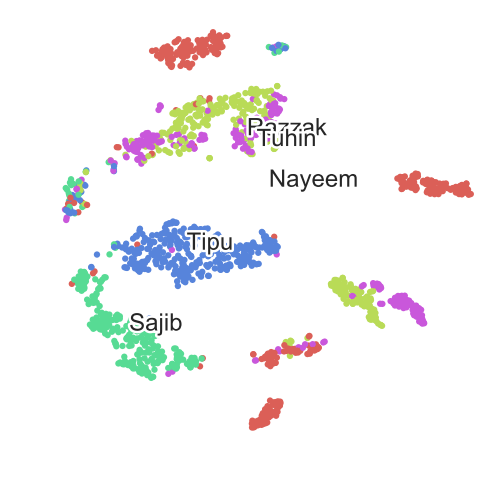

In [16]:
print(X_train.shape , y_train.shape)
scatter(X_train , y_train)

(749, 2) (749,) 5
0 : Nayeem
1 : Razzak
2 : Sajib
3 : Tipu
4 : Tuhin
[ -8.22807  -17.746687] ::  2
[ -7.0190487 -44.819324 ] ::  4
[ -4.532674 -35.112774] ::  1
[-31.442646  12.729388] ::  3
[-26.78175  13.70229] ::  3
12.255545 <class 'numpy.float32'>
24.433514 <class 'numpy.float32'>
-10.363218 <class 'numpy.float32'>
-26.517454 <class 'numpy.float32'>
16.978664 <class 'numpy.float32'>


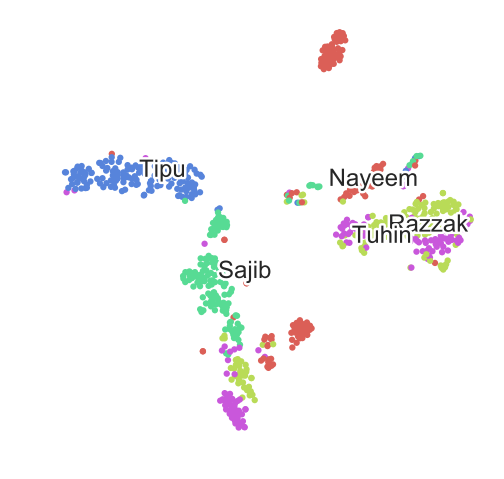

In [17]:
scatter(X_test , y_test)

# Define Necessary function

In [18]:
from itertools import permutations

def generate_triplet(x,y,testsize=0.3,ap_pairs=10,an_pairs=10):
    data_xy = tuple([x,y])

    trainsize = 1-testsize

    triplet_train_pairs = []
    triplet_test_pairs = []
    for data_class in sorted(set(data_xy[1])):

        same_class_idx = np.where((data_xy[1] == data_class))[0]
        diff_class_idx = np.where(data_xy[1] != data_class)[0]
        A_P_pairs = random.sample(list(permutations(same_class_idx,2)),k=ap_pairs) #Generating Anchor-Positive pairs
        Neg_idx = random.sample(list(diff_class_idx),k=an_pairs)
        

        #train
        A_P_len = len(A_P_pairs)
        Neg_len = len(Neg_idx)
        for ap in A_P_pairs[:int(A_P_len*trainsize)]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_train_pairs.append([Anchor,Positive,Negative])               
        #test
        for ap in A_P_pairs[int(A_P_len*trainsize):]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_test_pairs.append([Anchor,Positive,Negative])    
                
    return np.array(triplet_train_pairs), np.array(triplet_test_pairs)

In [19]:
import scipy
from keras.layers import merge

def cos_distance(y_true, y_pred):
    y_true = K.l2_normalize(y_true, axis=-1)
    y_pred = K.l2_normalize(y_pred, axis=-1)
    return K.mean(1 - K.sum((y_true * y_pred), axis=-1))

def triplet_loss(y_true, y_pred, alpha = 10000000000):

#     print('y_pred.shape = ',y_pred.shape)
    
    total_lenght = y_pred.shape.as_list()[-1]
#     print('total_lenght=',  total_lenght)
    
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)
#     pos_cos  = cos_distance(anchor, positive)
#     pos_dist = pos_cos

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
#     neg_cos  = cos_distance(anchor, negative)
#     neg_dist = neg_cos
    
#     print(pos_cos.eval() , neg_cos.eval())
#     print(pos_dist.eval() , neg_dist.eval())
    
    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    
    loss = K.maximum(basic_loss,0.0)
    
    no_tune = pos_dist - neg_dist 
    
#     print(">>> ", basic_loss.eval(), loss.eval(), no_tune.eval())

    
    return loss

In [20]:
# cos_distance(Anchor[20], Negative[20]).eval()

In [21]:
# Anchor[5], Positive[5], Negative[5]

In [22]:
# anc = X_train_triplet[15][0]
# pos = X_train_triplet[15][1]
# neg = X_train_triplet[15][2]

In [23]:
# pred = np.concatenate((anc,pos,neg)).reshape(1,81)

In [24]:
# sess = tf.InteractiveSession()

In [25]:
# loss = triplet_loss(y_true=None, y_pred=tf.constant(pred))

In [26]:
# loss.eval()

In [27]:
X_train_triplet, X_test_triplet = generate_triplet(X_train,y_train, ap_pairs=500, an_pairs=500,testsize=0.2)
print(X_train_triplet.shape , X_test_triplet.shape)

(1000000, 3, 27) (250000, 3, 27)


# Model

In [28]:
def create_linear_network(in_dims):
    print(in_dims , type(in_dims))
    
    model = Sequential()
    model.add(Conv1D(40, (3), input_shape=(27,1), activation='relu', name='conv1'))
    model.add(MaxPooling1D(3, padding='same',name='pool1'))
    model.add(Conv1D(256, (5), padding='same', activation='relu', name='conv2'))
    model.add(MaxPooling1D(2, padding='same',name='pool2'))
    model.add(Flatten(name='flatten'))
#     model.add(Dense(64, activation='softmax'))
    model.add(Dense(20,name='embeddings'))
    
    return model

In [29]:
def create_2D_network(in_dims):
    print(in_dims , type(in_dims))
    
    model = Sequential()
    model.add(Conv2D(128,(7,7),padding='same',input_shape=(in_dims[0], in_dims[1], in_dims[2]),activation='relu',name='conv1'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool1'))
    model.add(Conv2D(256,(5,5),padding='same',activation='relu',name='conv2'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool2'))
    model.add(Dropout(0.2))
    model.add(Flatten(name='flatten'))
    model.add(Dense(400, activation='relu', name='seq_1'))
    model.add(Dropout(0.2))
    model.add(Dense(250, activation='relu', name='seq_2'))
    model.add(Dense(25,name='embeddings'))
    
    return model

In [84]:
def create_2D_network_20_15(in_dims):
    print(in_dims , type(in_dims))
    
    model = Sequential()
    model.add(Conv2D(50,(3,3),padding='same',input_shape=(in_dims[0], in_dims[1], in_dims[2]),activation='relu',name='conv1'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool1'))
    model.add(Conv2D(100,(5,5),padding='same',activation='relu',name='conv2'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool2'))
    model.add(Dropout(0.2))
    model.add(Flatten(name='flatten'))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(150, activation='relu'))
    model.add(Dense(20,name='embeddings'))
    
    return model

In [73]:
adam_optim = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)

In [85]:
shape = (3,3,3)

anchor_input = Input(shape, name='anchor_input')
positive_input = Input(shape, name='positive_input')
negative_input = Input(shape, name='negative_input')

# Shared embedding layer for positive and negative items
Shared_DNN = create_2D_network_20_15(shape)


encoded_anchor = Shared_DNN(anchor_input)
encoded_positive = Shared_DNN(positive_input)
encoded_negative = Shared_DNN(negative_input)


merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

model = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model.compile(loss=triplet_loss, optimizer=adam_optim)

(3, 3, 3) <class 'tuple'>


In [86]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 3, 3, 3)      0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 3, 3, 3)      0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 3, 3, 3)      0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 20)           179870      anchor_input[0][0]               
                                                                 positive_input[0][0]             
          

In [87]:
def seperateTriplets(triplet, limit=None):
    Anchor = []
    Positive = []
    Negative = []
    
    if(limit==None):
        limit = triplet.shape[0]
    for i in range(limit):
        Anchor.append(triplet[i][0])
        Positive.append(triplet[i][1])
        Negative.append(triplet[i][2])
    
    return np.array(Anchor), np.array(Positive), np.array(Negative)

In [88]:
Anchor, Positive, Negative = seperateTriplets(X_train_triplet)
Anchor = Anchor.reshape([-1]+list(shape))
Positive = Positive.reshape([-1]+list(shape))
Negative = Negative.reshape([-1]+list(shape))

Anchor_test, Positive_test, Negative_test = seperateTriplets(X_test_triplet)
Anchor_test = Anchor_test.reshape([-1]+list(shape))
Positive_test = Positive_test.reshape([-1]+list(shape))
Negative_test = Negative_test.reshape([-1]+list(shape))

print(X_train.shape, X_test.shape)
print("TRAIN:" , Anchor.shape , Positive.shape, Negative.shape)
print("TEST:" , Anchor_test.shape , Positive_test.shape, Negative_test.shape)

(1519, 27) (749, 27)
TRAIN: (1000000, 3, 3, 3) (1000000, 3, 3, 3) (1000000, 3, 3, 3)
TEST: (250000, 3, 3, 3) (250000, 3, 3, 3) (250000, 3, 3, 3)


In [82]:
# checkpoint
folder_name = "model_20_5"

try:
    os.mkdir(folder_name)
    print("Created directory:: " , folder_name)
except:
    print("Directory already exists")

filepath=folder_name + "/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"

Directory already exists


In [ ]:
from keras.callbacks import ModelCheckpoint


Y_dummy = np.empty((Anchor.shape[0],100))
Y_dummy2 = np.empty((Anchor_test.shape[0],1))

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

model.fit(
    [Anchor,Positive,Negative],
    y=Y_dummy,
    validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2), 
    batch_size=100, 
    epochs=120,
    callbacks=callbacks_list
)

Train on 1000000 samples, validate on 250000 samples
Epoch 1/120
1000000/1000000 [==============================] - 83s 83us/step - loss: 2783488495.5168 - val_loss: 1696287533.1057

Epoch 00001: loss improved from inf to 2783488495.51680, saving model to model_20_5/weights-improvement-01-1696287533.11.hdf5
Epoch 2/120
1000000/1000000 [==============================] - 83s 83us/step - loss: 1276581179.1991 - val_loss: 1054877214.4214

Epoch 00002: loss improved from 2783488495.51680 to 1276581179.19910, saving model to model_20_5/weights-improvement-02-1054877214.42.hdf5
Epoch 3/120
1000000/1000000 [==============================] - 82s 82us/step - loss: 827305124.3227 - val_loss: 1013746750.1969

Epoch 00003: loss improved from 1276581179.19910 to 827305124.32269, saving model to model_20_5/weights-improvement-03-1013746750.20.hdf5
Epoch 4/120
1000000/1000000 [==============================] - 81s 81us/step - loss: 603753995.6923 - val_loss: 868170829.4196

Epoch 00004: loss improved 

1000000/1000000 [==============================] - 82s 82us/step - loss: 17336366.4637 - val_loss: 248196884.9970

Epoch 00032: loss did not improve from 17052782.86117
Epoch 33/120
1000000/1000000 [==============================] - 82s 82us/step - loss: 16264493.3696 - val_loss: 274568795.4711

Epoch 00033: loss improved from 17052782.86117 to 16264493.36956, saving model to model_20_5/weights-improvement-33-274568795.47.hdf5
Epoch 34/120
1000000/1000000 [==============================] - 81s 81us/step - loss: 14532124.2317 - val_loss: 315156070.6134

Epoch 00034: loss improved from 16264493.36956 to 14532124.23170, saving model to model_20_5/weights-improvement-34-315156070.61.hdf5
Epoch 35/120
1000000/1000000 [==============================] - 81s 81us/step - loss: 14521396.0790 - val_loss: 219008306.0744

Epoch 00035: loss improved from 14532124.23170 to 14521396.07905, saving model to model_20_5/weights-improvement-35-219008306.07.hdf5
Epoch 36/120
1000000/1000000 [===============

In [38]:
model_json = model.to_json()
with open("model_2D_20_5.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_2D_20_5.h5")
print("Saved model to disk")

Saved model to disk


# Load weights

In [40]:
trained_model = Model(inputs=anchor_input, outputs=encoded_anchor)
trained_model.load_weights('model_2D_25_150.h5')

In [41]:
tsne = TSNE()
X_train_trm = trained_model.predict(X_train.reshape([-1]+list(shape)))
X_test_trm = trained_model.predict(X_test.reshape([-1]+list(shape)))
train_tsne_embeds = tsne.fit_transform(X_train_trm)
eval_tsne_embeds = tsne.fit_transform(X_test_trm)

(1519, 2) (1519,) 5
0 : Nayeem
1 : Razzak
2 : Sajib
3 : Tipu
4 : Tuhin
[32.76715  30.968485] ::  3
[-51.71757     8.3396845] ::  4
[-52.821484    6.8387575] ::  4
[  6.823325 -47.433865] ::  1
[41.324608  -1.4274697] ::  3
-24.28883 <class 'numpy.float32'>
9.324558 <class 'numpy.float32'>
0.39690906 <class 'numpy.float32'>
39.081287 <class 'numpy.float32'>
-51.795197 <class 'numpy.float32'>


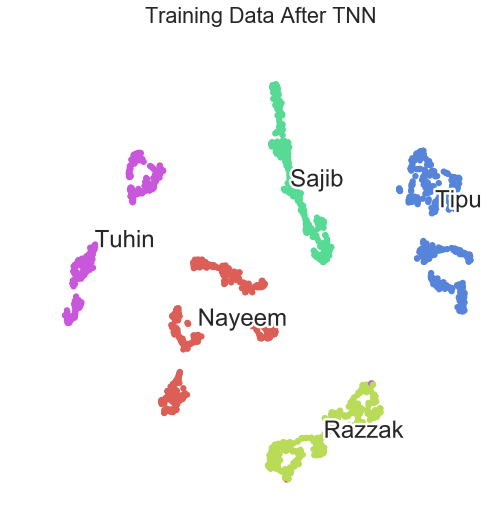

In [42]:
scatter(train_tsne_embeds, y_train, "Training Data After TNN")

(749, 2) (749,) 5
0 : Nayeem
1 : Razzak
2 : Sajib
3 : Tipu
4 : Tuhin
[14.701991 38.84941 ] ::  2
[12.42466   -1.1014103] ::  4
[-24.546288  19.125662] ::  1
[ 16.636002 -35.099297] ::  3
[ 18.188171 -39.032856] ::  3
-22.084892 <class 'numpy.float32'>
-26.399582 <class 'numpy.float32'>
11.162428 <class 'numpy.float32'>
20.595741 <class 'numpy.float32'>
10.813823 <class 'numpy.float32'>


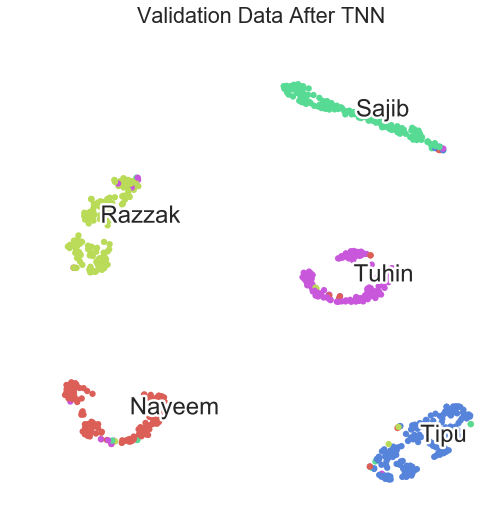

In [43]:
scatter(eval_tsne_embeds, y_test, "Validation Data After TNN")

# Checking Model Behaviour

In [44]:
def Concatenate2Data(arr , brr):
    print(arr.shape, brr.shape)
    ret = []
    for i in range(arr.shape[0]):
        ret.append(arr[i])
    for i in range(brr.shape[0]):
        ret.append(brr[i])
    ret = np.array(ret)
    print(">>> " , ret.shape)
    return ret

In [45]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

train_tsne = pca.fit_transform(X_train_trm)
test_tsne_embeds = pca.transform(X_test_trm)
print(test_tsne_embeds.shape)

user_data = [
    ('Arnab', 1,  1),
    ('Arnab2', 1,  1)
]
A_train, B_train = loadNewData(user_data , "new_data_A1")
print('>>>>>>>>>>>>>>>>>>>>>>>>> loaded train dataset :: ' , A_train.shape , B_train.shape)

(749, 2)
[92.]
<class 'numpy.ndarray'> (1,)
Arnab 1 :: 1 (88, 27)
[114.]
<class 'numpy.ndarray'> (1,)
Arnab2 1 :: 1 (51, 27)
>>>>>>>>>>>>>>>>>>>>>>>>> loaded train dataset ::  (139, 27) (139,)


In [46]:
eval_arnab= trained_model.predict(A_train.reshape([-1]+list(shape)))
eval_arnab = pca.transform(eval_arnab)

In [47]:
B_train.shape, y_test.shape

((139,), (749,))

In [48]:
eval_test_vectors = []

for i in range(eval_arnab.shape[0]):
    eval_test_vectors.append(eval_arnab[i])
    
    
for i in range(eval_tsne_embeds.shape[0]):
    eval_test_vectors.append(eval_tsne_embeds[i])

eval_test_labels = Concatenate2Data(B_train, y_test)
eval_test_vectors = np.array(eval_test_vectors)

# print(y_test.shape)
(eval_test_vectors.shape, eval_test_labels.shape)

(139,) (749,)
>>>  (888,)


((888, 2), (888,))

(888, 2) (888,) 7
0 : Arnab
1 : Arnab2
2 : Nayeem
3 : Razzak
4 : Sajib
5 : Tipu
6 : Tuhin
[  7.547222 -37.373997] ::  0
[ 17.141893 -23.58415 ] ::  1
[ 11.408242 -32.742123] ::  0
[  9.178886 -36.096718] ::  0
[ 12.909249 -30.151573] ::  0
10.393783 <class 'numpy.float32'>
17.141893 <class 'numpy.float32'>
-33.825863 <class 'numpy.float32'>
3.5088918 <class 'numpy.float32'>
38.990837 <class 'numpy.float32'>
-2.8220148 <class 'numpy.float32'>
-24.892128 <class 'numpy.float32'>


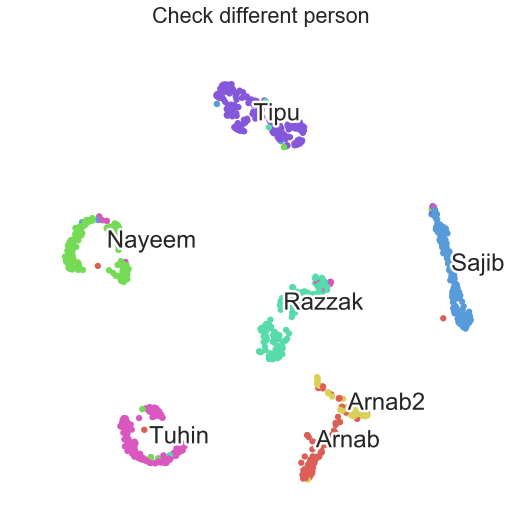

In [49]:
scatter(eval_test_vectors, eval_test_labels, "Check different person")

In [50]:
from sklearn.model_selection import train_test_split
X_test1, X_test2, y_test1, y_test2 = train_test_split(X_test, y_test, test_size=0.50, random_state=31)

In [51]:
print(X_test1.shape, y_test1.shape)
print(X_test2.shape, y_test2.shape)

(374, 27) (374,)
(375, 27) (375,)


In [52]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

X_test_trm1 = trained_model.predict(X_test1.reshape([-1]+list(shape)))
X_test_trm2 = trained_model.predict(X_test2.reshape([-1]+list(shape)))

train_tsne = pca.fit_transform(X_train_trm)

tsne_embeds1 = pca.transform(X_test_trm1)
tsne_embeds2 = pca.transform(X_test_trm2)

print(tsne_embeds1.shape, tsne_embeds2.shape)

(374, 2) (375, 2)


In [53]:
tsne_merged = []
label_merged = []

for i in range(tsne_embeds1.shape[0]):
    tsne_merged.append(tsne_embeds1[i])
    label_merged.append(y_test1[i])
    
    
for i in range(tsne_embeds2.shape[0]):
    tsne_merged.append(tsne_embeds2[i])
    label_merged.append(str(y_test2[i]) + "2")

tsne_merged = np.array(tsne_merged)
label_merged = np.array(label_merged)

# print(y_test.shape)
(tsne_merged.shape, label_merged.shape)

((749, 2), (749,))

(749, 2) (749,) 10
0 : Nayeem
1 : Nayeem2
2 : Razzak
3 : Razzak2
4 : Sajib
5 : Sajib2
6 : Tipu
7 : Tipu2
8 : Tuhin
9 : Tuhin2
[16.649067   0.7252512] ::  0
[35.620186 20.992445] ::  0
[-37.666824    4.9208865] ::  2
[12.542894 -2.909292] ::  8
[-25.890835   4.495316] ::  2
40.112724 <class 'numpy.float32'>
42.092957 <class 'numpy.float32'>
-34.762394 <class 'numpy.float32'>
-31.27077 <class 'numpy.float32'>
-6.202626 <class 'numpy.float32'>
-5.9698896 <class 'numpy.float32'>
-4.4799294 <class 'numpy.float32'>
-4.344608 <class 'numpy.float32'>
13.670127 <class 'numpy.float32'>
14.233462 <class 'numpy.float32'>


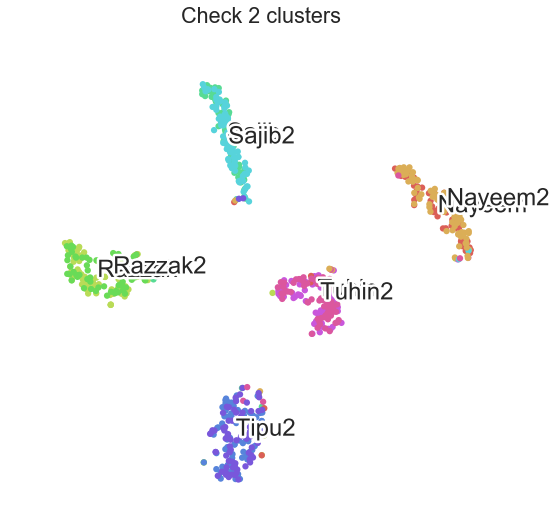

In [54]:
scatter(tsne_merged, label_merged, "Check 2 clusters")

# Base Model (original)

In [55]:
X_train.shape, y_train.shape

((1519, 27), (1519,))

In [56]:
from xgboost import XGBClassifier
param = {
    'max_depth': 5,  
    'eta': 0.01, 
    'silent': 1, 
    'objective': 'multi:softprob',  
    'num_class': 5
}  
bst = XGBClassifier(max_depth = 7)
bst.fit(X_train , y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [57]:
pred_xgb = bst.predict(X_test)
score = sklearn.metrics.accuracy_score(y_test, pred_xgb)
print("accuracy: {}%".format(score*100))

accuracy: 95.86114819759679%


Confusion matrix, with little normalization


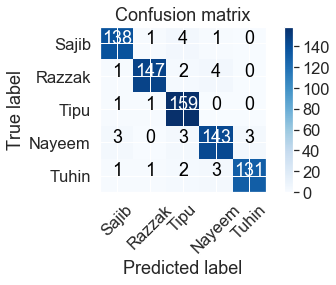

In [58]:
cm = sklearn.metrics.confusion_matrix(y_test, pred_xgb, labels=list(set(y_train)))
plot_confusion_matrix(cm, classes=list(set(y_train)))

In [59]:
pred_xgb = bst.predict(A_train)

In [60]:
pred_xgb[0:10]

array(['Nayeem', 'Sajib', 'Nayeem', 'Razzak', 'Nayeem', 'Sajib', 'Sajib',
       'Nayeem', 'Razzak', 'Sajib'], dtype='<U6')

# Processed Model

In [61]:
X_train_trm.shape, y_train.shape

((1519, 25), (1519,))

In [62]:
from xgboost import XGBClassifier
param = {
    'max_depth': 5,  
    'eta': 0.01, 
    'silent': 1, 
    'objective': 'multi:softprob',  
    'num_class': 5
}  
bst2 = XGBClassifier(max_depth = 7)
bst2.fit(X_train_trm , y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [63]:
pred_xgb2 = bst2.predict(X_test_trm)
score = sklearn.metrics.accuracy_score(y_test, pred_xgb2)
print("accuracy: {}%".format(score*100))

accuracy: 94.65954606141523%


In [64]:
A_train_trm = trained_model.predict(A_train.reshape([-1]+list(shape)))
bst2.predict(A_train_trm)[0:10]

array(['Razzak', 'Nayeem', 'Razzak', 'Razzak', 'Nayeem', 'Tuhin',
       'Nayeem', 'Nayeem', 'Razzak', 'Nayeem'], dtype='<U6')